In [59]:
import re
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import numpy as np
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import sent_tokenize
from nltk.stem.snowball import SnowballStemmer


from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split


import string
string.punctuation
from nltk.tokenize import TweetTokenizer
from nltk.tokenize.api import TokenizerI
from nltk.stem import StemmerI, WordNetLemmatizer

!pip install contractions
import contractions
from typing import List

import matplotlib.pyplot as plt
from matplotlib.figure import Figure

from scipy import sparse
from sklearn.preprocessing import StandardScaler    # only for std on csr_matrix

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vrajp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vrajp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vrajp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\vrajp\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Dataset_2: Sentiment140



In [4]:
DS_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DS_ENCODING = "ISO-8859-1"

df_train = pd.read_csv("https://www.cs.mcgill.ca/~aislam18/backup/training.1600000.processed.noemoticon.csv", 
                       encoding=DS_ENCODING, names=DS_COLUMNS, dtype={'sentiment': 'int8','text' : 'string'})
df_train

df_test = pd.read_csv("https://www.cs.mcgill.ca/~aislam18/backup/new_testdata.manual.2009.06.14.csv", 
                      encoding=DS_ENCODING, names=DS_COLUMNS, dtype={'sentiment': 'int8','text' : 'string'})
df_test

print(df_train.dtypes)
print(df_train.shape)

print(df_test.dtypes)
print(df_test.shape)

sentiment      int8
ids           int64
date         object
flag         object
user         object
text         string
dtype: object
(1600000, 6)
sentiment      int8
ids           int64
date         object
flag         object
user         object
text         string
dtype: object
(359, 6)


In [5]:
df_train.head()

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
df_test.head()

,sentiment,ids,date,flag,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


## Data cleaning 

Since we do not need the columns 'ids', 'date', 'flag' and 'user' we remove them from both train and test set

In [7]:
sentiment_train_df = df_train.drop(columns=['ids', 'date', 'flag','user'], axis=1) #[['sentiment', 'text']]
# Positive tweets have a value of 4 that we will convert to 1 for a binary column
sentiment_train_df['sentiment'] = sentiment_train_df['sentiment'].replace(4, 1)

In [8]:
sentiment_train_df_processed = sentiment_train_df.copy()

In [9]:
sentiment_test_df = df_test.drop(columns=['ids', 'date', 'flag','user'], axis=1) #[['sentiment', 'text']]
# Positive tweets have a value of 4 that we will convert to 1 for a binary column
sentiment_test_df['sentiment'] = sentiment_test_df['sentiment'].replace(4, 1)

In [10]:
sentiment_train_df['text']

0          @switchfoot http://twitpic.com/2y1zl - Awww, t...
1          is upset that he can't update his Facebook by ...
2          @Kenichan I dived many times for the ball. Man...
3            my whole body feels itchy and like its on fire 
4          @nationwideclass no, it's not behaving at all....
                                 ...                        
1599995    Just woke up. Having no school is the best fee...
1599996    TheWDB.com - Very cool to hear old Walt interv...
1599997    Are you ready for your MoJo Makeover? Ask me f...
1599998    Happy 38th Birthday to my boo of alll time!!! ...
1599999    happy #charitytuesday @theNSPCC @SparksCharity...
Name: text, Length: 1600000, dtype: string

In [11]:
sentiment_test_df['text']

0      @stellargirl I loooooooovvvvvveee my Kindle2. ...
1      Reading my kindle2...  Love it... Lee childs i...
2      Ok, first assesment of the #kindle2 ...it fuck...
3      @kenburbary You'll love your Kindle2. I've had...
4      @mikefish  Fair enough. But i have the Kindle2...
                             ...                        
354    After using LaTeX a lot, any other typeset mat...
355    On that note, I hate Word. I hate Pages. I hat...
356    Ahhh... back in a *real* text editing environm...
357    Trouble in Iran, I see. Hmm. Iran. Iran so far...
358    Reading the tweets coming out of Iran... The w...
Name: text, Length: 359, dtype: string

## Plotting Distribution of classes

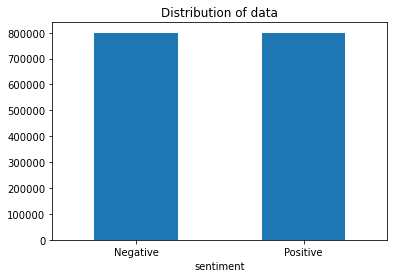

In [12]:
# Plotting the distribution for dataset.
ax = sentiment_train_df.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                                          legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text_train, sentiment_train = list(sentiment_train_df['text']), list(sentiment_train_df['sentiment'])

Since the classes are balanced and there is no skewness, we proceed to preprocess the data.

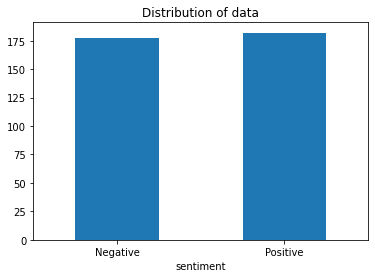

In [13]:
# Plotting the distribution for dataset.
ax = sentiment_test_df.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                                          legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text_test, sentiment_test = list(sentiment_test_df['text']), list(sentiment_test_df['sentiment'])

## Text Preprocessing

Tweet texts often consists of other user mentions, hyperlink texts, emoticons and punctuations. In order to use them for learning using a Language Model. We cannot permit those texts for training a model. So we have to clean the text data using various preprocessing and cleansing methods.

### Stemming/ Lematization:
Stemming usually refers to a process that chops off the ends of words in the hope of achieving goal correctly most of the time and often includes the removal of derivational affixes.

Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base and dictionary form of a word.

### Hyperlinks and Mentions:
Twitter is a social media platform where people can tag and mentions other people's ID and share videos and blogs from internet. So the tweets often contain lots of Hyperlinks and twitter mentions.

### Stopwords:
Stopwords are commonly used words in English which have no contextual meaning. So we remove them before classification.

In [14]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|www?:\S|[^A-Za-z0-9]+"
sentiment_train_df['text'] = sentiment_train_df['text'].str.replace('\d+', '')

C:\Users\vrajp\AppData\Local\Temp/ipykernel_18868/4010953658.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  sentiment_train_df['text'] = sentiment_train_df['text'].str.replace('\d+', '')


In [15]:
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Since not all there are some expressions that do not give us enough information, we extend it as the stopwords.

In [16]:
stop_words.extend(['aww','awww','ah','ahh','ahhh','haha','hahaha','guys'])

In [17]:
def preprocess(text, stem=False):
    text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
    tokens = []
    #print(tokens.type)
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [18]:
# It takes ~ 1.5 minutes to process it on avg.
sentiment_train_df['text'] = sentiment_train_df['text'].apply(lambda x: preprocess(x))

In [19]:
sentiment_test_df['text'] = sentiment_test_df['text'].apply(lambda x: preprocess(x))

## Preprocessed_data visualization

In [20]:
sentiment_train_df['text']

0                    bummer shoulda got david carr third day
1          upset update facebook texting might cry result...
2          dived many times ball managed save rest go bounds
3                           whole body feels itchy like fire
4                                           behaving mad see
                                 ...                        
1599995                        woke school best feeling ever
1599996             thewdb com cool hear old walt interviews
1599997                      ready mojo makeover ask details
1599998    happy th birthday boo alll time tupac amaru sh...
1599999    happy charitytuesday thenspcc sparkscharity sp...
Name: text, Length: 1600000, dtype: object

In [21]:
sentiment_test_df['text']

0      loooooooovvvvvveee kindle2 dx cool 2 fantastic...
1              reading kindle2 love lee childs good read
2               ok first assesment kindle2 fucking rocks
3      love kindle2 mine months never looked back new...
4                      fair enough kindle2 think perfect
                             ...                        
354    using latex lot typeset mathematics looks hideous
355    note hate word hate pages hate latex said hate...
356        back real text editing environment lt 3 latex
357    trouble iran see hmm iran iran far away flocko...
358    reading tweets coming iran whole thing terrify...
Name: text, Length: 359, dtype: object

## Extracting Feature vectors using CountVectorizer and tfidfTransformer 

In [22]:
vectorizer = CountVectorizer(ngram_range=(1, 1), stop_words='english', min_df=0.004, max_df=1.0)
vectorizer_transformer = vectorizer.fit(sentiment_train_df['text'])
x_train_cv = vectorizer_transformer.fit_transform(sentiment_train_df['text'])   #bag of words

tf_transformer = TfidfTransformer(use_idf=False).fit(x_train_cv)
x_train_tf = tf_transformer.transform(x_train_cv)

In [23]:
x_train_tf

<1600000x226 sparse matrix of type '<class 'numpy.float64'>'
	with 3800514 stored elements in Compressed Sparse Row format>

In [24]:
x_train_2 = x_train_tf
y_train_2 = sentiment_train_df['sentiment'].to_numpy()

## Fit the train_set as vectorizer_transformer and using this to transform test data

In [25]:
vectorizer_transformer = vectorizer.fit(sentiment_train_df['text'])
x_test_cv = vectorizer_transformer.transform(sentiment_test_df['text'])   #bag of words

tf_transformer = TfidfTransformer(use_idf=False).fit(x_test_cv)
x_test_tf = tf_transformer.transform(x_test_cv)

In [26]:
x_test_2 = x_test_tf
y_test_2 = sentiment_test_df['sentiment'].to_numpy()

## Some useful analysis on the dataset using unigram, bigram and trigram

In [27]:
# Setup compiled regular expressions for tokenization
NON_ALNUM_RE = re.compile(r'[^a-zA-Z0-9]')
USER_RE = re.compile('@[^\s]+')
HTTP_URL_RE = re.compile("((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)")
SPACES_RE = re.compile('[\s]+')

# Setup tokenizer and lemmatizer
wn_lemmatizer = WordNetLemmatizer()
tw_tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True)

In [28]:
def make_ngrams(words: List[str], n: int = 1) -> List[str]:

    if n == 1 or not words or n > len(words):
        return words
    # Otherwise we process n-gram windows and proceed
    n_grams = []
    for i in range(len(words) - n + 1):
        n_grams.append('_'.join(words[i:i+n]))
    return n_grams

In [29]:
def stem_and_tokenize(origin_text: str,
                      lemmatizer: WordNetLemmatizer,
                      tokenizer: TokenizerI,
                      n_grams: int = 1) -> List[str]:

    text = origin_text.lower()
    # Replace the URLs and usernames
    text = HTTP_URL_RE.sub(' ', text) # 'url'
    text = USER_RE.sub(' ', text)  #user
    # Expand contractions before additional processing
    text = contractions.fix(text)
    # Replace non alpha numeric characters with empty string
    text = NON_ALNUM_RE.sub(' ', text)
    text = SPACES_RE.sub(' ', text)
    # Tokenize the processed text and make n-grams
    tokens = tokenizer.tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return make_ngrams(tokens, n_grams)

In [30]:
def make_tokens(row_data: str, n_grams: int = 1) -> List[str]:

    return stem_and_tokenize(row_data, wn_lemmatizer, tw_tokenizer, n_grams=n_grams)


In [31]:
local_len = len

# sentiment_train_df_processed = sentiment_train_df.copy()
sentiment_train_df_processed['tokens'] = sentiment_train_df_processed['text'].apply(make_tokens)
sentiment_train_df_processed['text_length'] = sentiment_train_df_processed['text'].apply(local_len)

In [32]:
sentiment_train_df_processed

,sentiment,text,tokens,text_length
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","[bummer, shoulda, got, david, carr, third, day]",115
1,0,is upset that he can't update his Facebook by ...,"[upset, cannot, update, facebook, texting, mig...",111
2,0,@Kenichan I dived many times for the ball. Man...,"[dived, many, time, ball, managed, save, 50, r...",89
3,0,my whole body feels itchy and like its on fire,"[whole, body, feel, itchy, like, fire]",47
4,0,"@nationwideclass no, it's not behaving at all....","[behaving, mad, cannot, see]",111
...,...,...,...,...
1599995,1,Just woke up. Having no school is the best fee...,"[woke, school, best, feeling, ever]",56
1599996,1,TheWDB.com - Very cool to hear old Walt interv...,"[thewdb, com, cool, hear, old, walt, interview]",78
1599997,1,Are you ready for your MoJo Makeover? Ask me f...,"[ready, mojo, makeover, ask, detail]",57
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...,"[happy, 38th, birthday, boo, alll, time, tupac...",65


### Setup n-gram strings

In [33]:
n_gram_options = {
    'unigrams': 1,
    'bigrams': 2,
    'trigrams': 3,
}

for n_gram, n in n_gram_options.items():
    sentiment_train_df_processed[n_gram] = sentiment_train_df_processed['tokens'].apply(lambda x: ' '.join(make_ngrams(x, n)))
    # Add string length, token:text ratio for unigrams only
    if n == 1:
        sentiment_train_df_processed[f"{n_gram}_length"] = sentiment_train_df_processed[n_gram].apply(len)
        sentiment_train_df_processed['unigram_to_text'] = sentiment_train_df_processed[f"{n_gram}_length"]/sentiment_train_df_processed['text_length']

sentiment_train_df_processed

,sentiment,text,tokens,text_length,unigrams,unigrams_length,unigram_to_text,bigrams,trigrams
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","[bummer, shoulda, got, david, carr, third, day]",115,bummer shoulda got david carr third day,39,0.339130,bummer_shoulda shoulda_got got_david david_car...,bummer_shoulda_got shoulda_got_david got_david...
1,0,is upset that he can't update his Facebook by ...,"[upset, cannot, update, facebook, texting, mig...",111,upset cannot update facebook texting might cry...,76,0.684685,upset_cannot cannot_update update_facebook fac...,upset_cannot_update cannot_update_facebook upd...
2,0,@Kenichan I dived many times for the ball. Man...,"[dived, many, time, ball, managed, save, 50, r...",89,dived many time ball managed save 50 rest go b...,50,0.561798,dived_many many_time time_ball ball_managed ma...,dived_many_time many_time_ball time_ball_manag...
3,0,my whole body feels itchy and like its on fire,"[whole, body, feel, itchy, like, fire]",47,whole body feel itchy like fire,31,0.659574,whole_body body_feel feel_itchy itchy_like lik...,whole_body_feel body_feel_itchy feel_itchy_lik...
4,0,"@nationwideclass no, it's not behaving at all....","[behaving, mad, cannot, see]",111,behaving mad cannot see,23,0.207207,behaving_mad mad_cannot cannot_see,behaving_mad_cannot mad_cannot_see
...,...,...,...,...,...,...,...,...,...
1599995,1,Just woke up. Having no school is the best fee...,"[woke, school, best, feeling, ever]",56,woke school best feeling ever,29,0.517857,woke_school school_best best_feeling feeling_ever,woke_school_best school_best_feeling best_feel...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...,"[thewdb, com, cool, hear, old, walt, interview]",78,thewdb com cool hear old walt interview,39,0.500000,thewdb_com com_cool cool_hear hear_old old_wal...,thewdb_com_cool com_cool_hear cool_hear_old he...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...,"[ready, mojo, makeover, ask, detail]",57,ready mojo makeover ask detail,30,0.526316,ready_mojo mojo_makeover makeover_ask ask_detail,ready_mojo_makeover mojo_makeover_ask makeover...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...,"[happy, 38th, birthday, boo, alll, time, tupac...",65,happy 38th birthday boo alll time tupac amaru ...,52,0.800000,happy_38th 38th_birthday birthday_boo boo_alll...,happy_38th_birthday 38th_birthday_boo birthday...


### Count word_frequency using WordCloud

In [34]:
from collections import Counter
from typing import Tuple, List, Dict

class FrequencyCollection:
    """
    A simple class that contains positive, negative, and total frequency counts
    for the provided string.
    """

    def __init__(self, all_counts: Dict[str, int], pos: Dict[str, int], neg: Dict[str, int]):
        self.all_counts = all_counts
        self.pos = pos
        self.neg = neg


def create_frequency_counts(feature_col: str) -> Tuple[Dict[str, int], Dict[str, int], Dict[str, int]]:
    """
    Create frequency count dictionary for the given feature column from the
    processed data frame.

    :param feature_col: The name of the feature column of which to count.
    :type feature_col: str
    :return: A tuple consisting of all counts, positive counts, and negative counts
    :rtype: tuple on Python 3.x containing three dict objects
    """
    all_counts = Counter()
    pos_counts = Counter()
    neg_counts = Counter()

    def count_tokens_from_list(sentiment: int, tokens: List[str]):
        if sentiment == 0:
            neg_counts.update(tokens)
        else:
            pos_counts.update(tokens)
        all_counts.update(tokens)


    if feature_col == 'tokens':
        sentiment_train_df_processed.loc[sentiment_train_df_processed['sentiment'] == 0, feature_col].apply(lambda x: count_tokens_from_list(0, x))
        print("Finished counting negative tokens")
        sentiment_train_df_processed.loc[sentiment_train_df_processed['sentiment'] != 0, feature_col].apply(lambda x: count_tokens_from_list(1, x))
        print("Finished counting positive tokens")
    else:
        sentiment_train_df_processed.loc[sentiment_train_df_processed['sentiment'] == 0, feature_col].apply(lambda x: count_tokens_from_list(0, x.split(' ')))
        print(f"Finished counting negative {feature_col.title()}")
        sentiment_train_df_processed.loc[sentiment_train_df_processed['sentiment'] != 0, feature_col].apply(lambda x: count_tokens_from_list(1, x.split(' ')))
        print(f"Finished counting positive {feature_col.title()}")

    return FrequencyCollection(all_counts, pos_counts, neg_counts)


def word_cloud_from_dict(title: str,
                         sub_title: str,
                         word_counts: Dict[str, int],
                         fig: Figure, subplot: Tuple[int, int, int],
                         max_words: int = 100,
                         bg_color: str = 'white'):
    """
    Create a word cloud from the supplied frequency dictionary.

    The word cloud from dict function expects a dictionary representing
    the frequency of a given word in the given context. The function adds
    an image to the provided subplot location.

    """
    # Create the word cloud image
    wc = WordCloud(max_words=max_words, width=1600, height=800,
                   collocations=False,
                   background_color=bg_color)
    wc.generate_from_frequencies(word_counts)

    # Add to the provided figure and subplot
    fig.add_subplot(*subplot)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.title(f"{title.title()}\n{sub_title.title()} Sentiment", fontdict={'fontsize': 20})


def make_frequency_clouds(fig: Figure, pos_counts: Dict[str, int], neg_counts: Dict[str, int],
                          feature_col: str, rows: int, cols: int, idx: int, max_words: int = 100):
    """
    A helper function for creating word cloud comparisons using the positive or negative
    labeled text examples. Resulting images will be output to the relative path of ./images/
    for use in associated documentation.

    :param cleaned_data: The cleaned data frame for the sentiment140 training data. Assumed to be
                         in the sorted order such that the first 800000 rows contain negative examples.
    :type clened_data: pandas.core.frame.DataFrame
    :param feature_col: The feature column name that we want to make a word cloud from. This column must
                        contain a space separated string value for processing.
    :type feature_col: string
    """
    # Observation tells us that these words don't contribute much to the informative value of the figures
    word_cloud_from_dict(feature_col, "Negative", neg_counts, fig, (rows, cols, (2 * idx + 1)), bg_color='red')
    word_cloud_from_dict(feature_col, "Positive", pos_counts, fig, (rows, cols, (2 * idx + 2)), bg_color='whitesmoke')


In [35]:
# Create simple frequency count objects to work with

token_counts = create_frequency_counts('tokens')
bigrams_counts= create_frequency_counts('bigrams')
trigrams_counts = create_frequency_counts('trigrams')

frequency_counts= [token_counts, bigrams_counts, trigrams_counts]


Finished counting negative tokens
Finished counting positive tokens
Finished counting negative Bigrams
Finished counting positive Bigrams
Finished counting negative Trigrams
Finished counting positive Trigrams


In [36]:
# for feature_col in n_gram_options.keys():
#     fig = plt.figure(figsize=(16, 16))
#     rows, cols = 2, 2

#     make_frequency_clouds(fig, token_counts.pos, token_counts.neg, feature_col, rows, cols, 0)

#     fig.suptitle(f"Word Cloud Visualizations: {feature_col.title()}", fontsize=24)
#     fig.tight_layout()
# plt.show()
# plt.close()

### Histogram: Most Common N-Grams by Sentiment


In [37]:
def top_count_histogram(token_counts: FrequencyCollection,
                        feature_col: str,
                        n_most_common: int,
                        figsize: Tuple[int, int] = (16, 16)):


    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=figsize)

    # Plot histogram of the top 25 most common words for positive sentiment
    pos_token_df = pd.DataFrame(token_counts.pos.most_common(n_most_common), columns=['token', 'count'])
    pos_token_df[pos_token_df['token'] != ''].plot(x='token', y='count', kind='bar', title="Positive Token Counts", 
                                                   color='green' ,ax=axes[0])
    # Plot histogram of the top 25 most common words for negative sentiment
    neg_token_df = pd.DataFrame(token_counts.neg.most_common(n_most_common), columns=['token', 'count'])
    neg_token_df[neg_token_df['token'] != ''].plot(x='token', y='count', kind='bar', title="Negative Token Counts",
                                                   color='pink' ,ax=axes[1])
    for ax in axes:
        ax.title.set_size(20)
    fig.tight_layout(pad=10.0)
    fig.suptitle(f"Frequency Histogram: {feature_col.title()}", fontsize=24)
    plt.show()
    plt.close()


### Top 25 Token Counts - Unigrams



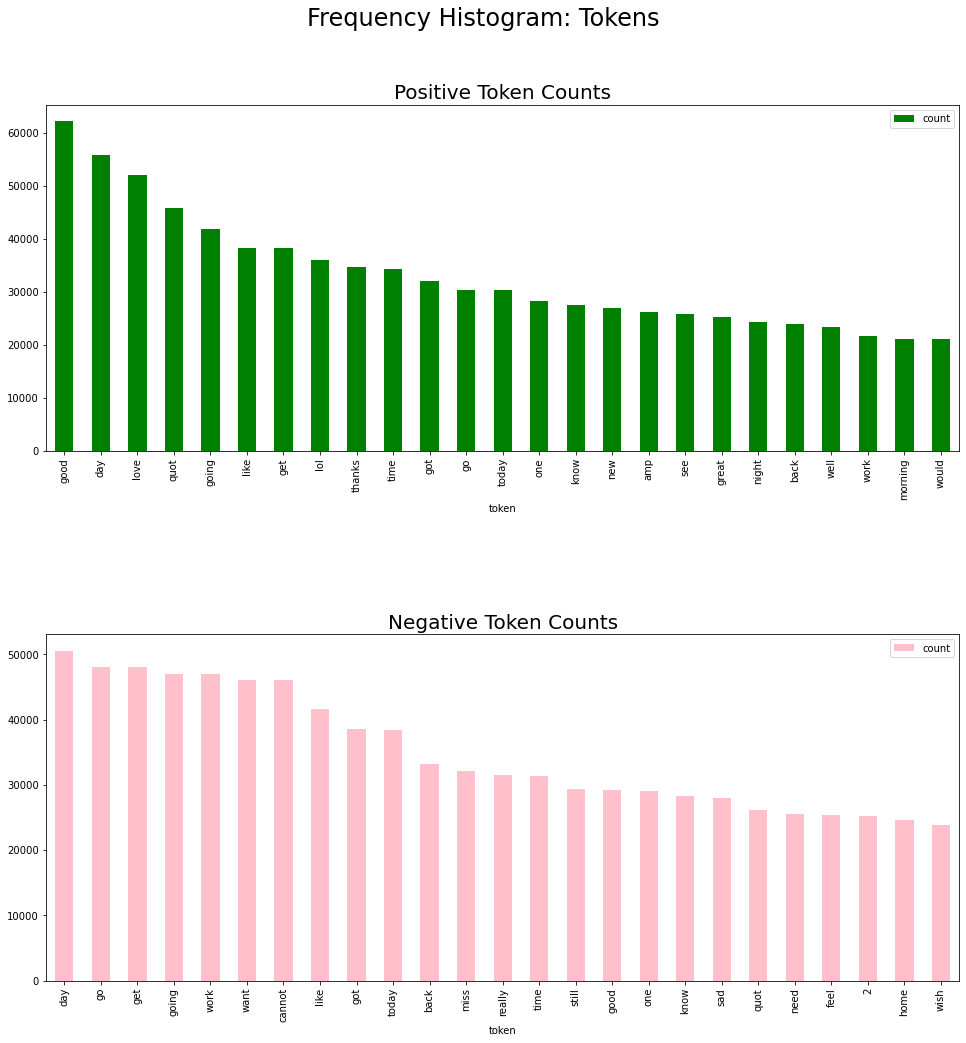

In [38]:
top_count_histogram(token_counts, 'tokens', 25)

### Top 25 Token Counts - Bigrams

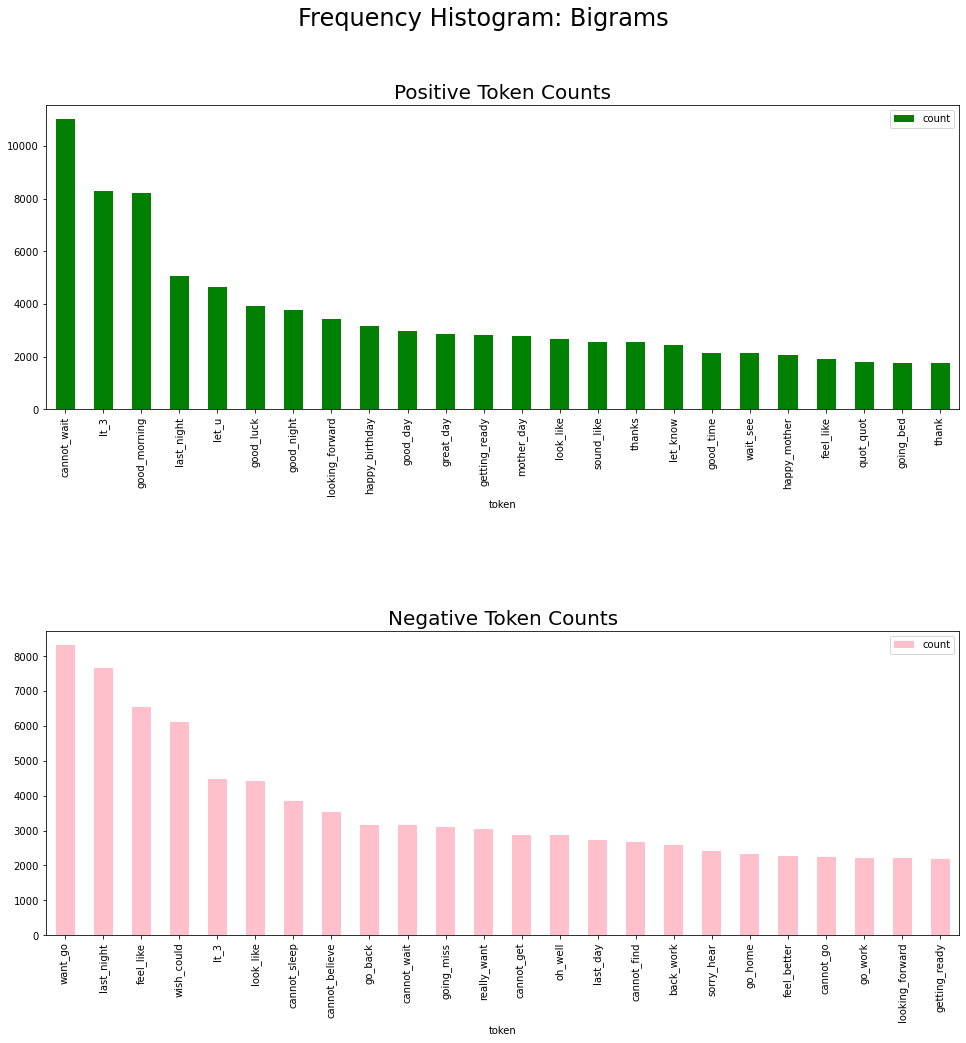

In [39]:
top_count_histogram(bigrams_counts, 'bigrams', 25)

### Top 25 Token Counts - Trigrams

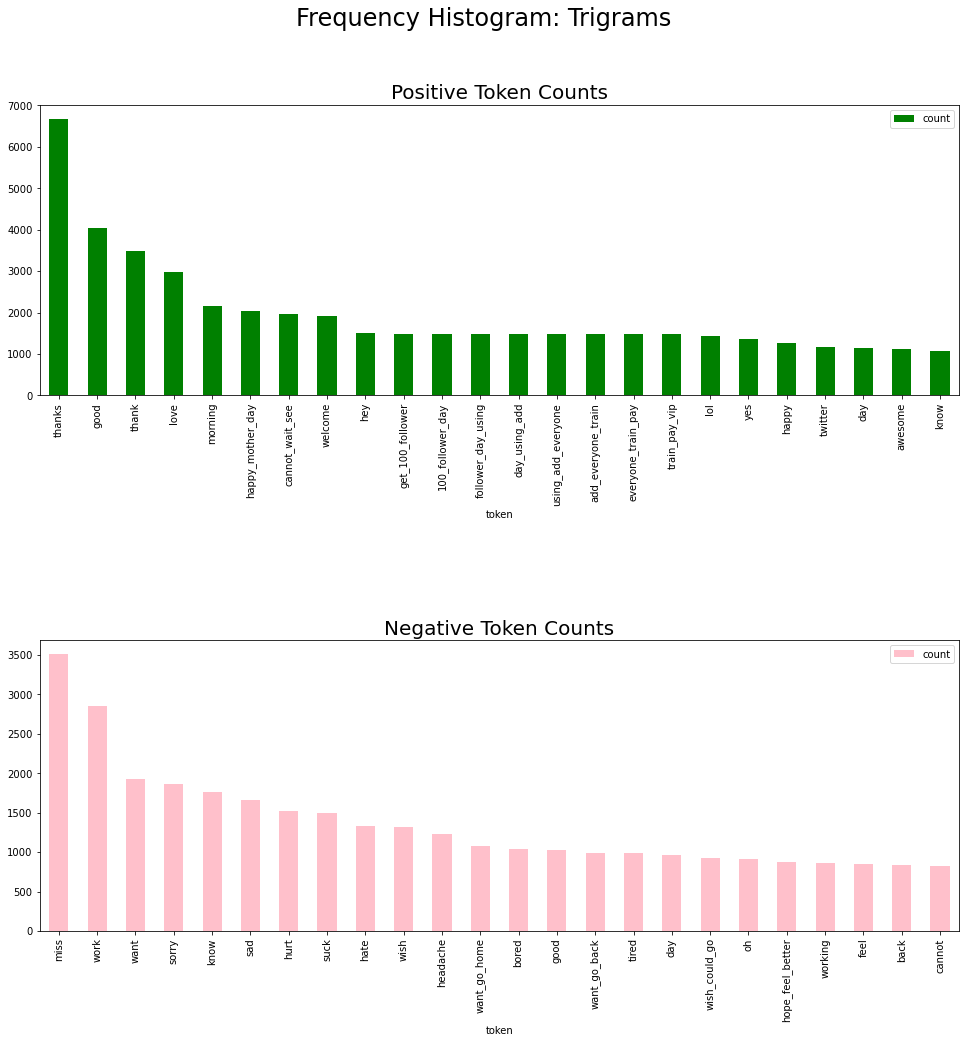

In [40]:
top_count_histogram(trigrams_counts, 'trigrams', 25)

# Naive Bayes

## Function and Class Definitions

### Accuracy/Error Function

In [41]:
# Calculate accuracy
evaluate_acc = lambda y_test, y_pred: np.sum(y_test == y_pred)/y_test.shape[0]*100
evaluate_err = lambda y_test, y_pred: (1-np.sum(y_test == y_pred)/y_test.shape[0])*100

### Gaussian Naive Bayes Class Definition

In [42]:
class GaussianNaiveBayes:
    
    def __init__(self):
        return
    
    def fit(self, x, y):
        N, D = x.shape
        C = np.max(y) + 1
        # one parameter for each feature conditioned on each class
        mu, sigma = np.zeros((C,D)), np.zeros((C,D))
        Nc = np.zeros(C) # number of instances in class c
        # for each class get the MLE for the mean and std
        scaler = StandardScaler(with_mean=False)
        for c in range(C):
            sum = np.zeros((1,D))
            sum_sqr = np.zeros((1,D))                       
            for i in range(x.shape[0]):               #slice all the elements from class c
                if (y[i] == c):
                    Nc[c] += 1                        #get number of elements of class c
                    sum = sum + x[i,:]
                    sum_sqr = sum_sqr + x[i,:].multiply(x[i,:])
            mu[c,:] = sum/Nc[c]                       #mean of features of class c
            sigma[c,:] = np.sqrt(sum_sqr - Nc[c] * np.square(sum))  #std of features of class c
            
        self.mu = mu                                  # C x D
        self.sigma = sigma + np.finfo(np.float64).eps # C x D (added eps to avoid divide-by-zero error)
        self.pi = (Nc+1)/(N+C)                        #Laplace smoothing (using alpha_c=1 for all c) you can derive using Dirichlet's distribution
        return self

def logsumexp(Z):                                                # dimension C x N
    Zmax = np.max(Z,axis=0)[None,:]                              # max over C
    log_sum_exp = Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=0))
    return log_sum_exp

def predict(self, xt):
    Nt, D = xt.shape
    # for numerical stability we work in the log domain
    # we add a dimension because this is added to the log-likelihood matrix 
    # that assigns a likelihood for each class (C) to each test point, and so it is C x N
    log_prior = np.log(self.pi)[:, None]
    # logarithm of the likelihood term for Gaussian 
    # the first two terms are the logarithm of the normalization term in the Gaussian and the final term is the exponent in the Gaussian. 
    # Notice that we are adding dimensions (using None) to model parameters and data to make this evaluation. 
    # The reason is that sigma and mu are C x D, while the data x is N x D. We operate on a C x N x D shape by increasing the number of dimensions when needed
    # Sparse matrices do NOT support 3D; instead we can loop through N data points and compute D likelihoods for each
    log_likelihood = np.zeros((Nt,self.mu.shape[0]))       # N x C
    for N in range(Nt):
        log_likelihood_N = -.5 * np.log(2*np.pi) - np.log(self.sigma) -.5 * np.square((sparse.csr_matrix(np.ones([self.mu.shape[0],1])) * xt[N,:] - self.mu)/self.sigma)    # C x D
        # now we sum over the feature dimension (this has the log-likelihood for each class-test point combination)
        log_likelihood[N,:] = np.sum(log_likelihood_N, axis=1).reshape((1,self.mu.shape[0]))   # 1 x C array
    # posterior calculation
    log_posterior = log_prior + log_likelihood.T
    posterior = np.exp(log_posterior - logsumexp(log_posterior))
    return posterior.T                                                  # dimension N x C

GaussianNaiveBayes.predict = predict

### Cross-Validation Function Definition

In [43]:
def cross_validation_split(n, n_folds=10):
    #get the number of data samples in each split
    n_val = n // n_folds
    for f in range(n_folds):
        val_start = f * n_val
        val_end = f * n_val + n_val - 1
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield val_start, val_end

## Running Experiments

### Preparation

In [44]:
# Feature selection
# N/A

# To sparse matrices
x2_rest = x_train_2
print(np.shape(x2_rest))
print(x2_rest.dtype)

y2_rest = y_train_2
print(np.shape(y2_rest))
print(y2_rest.dtype)

x2_test = x_test_2
print(np.shape(x2_test))
print(x2_test.dtype)

y2_test = y_test_2
print(np.shape(y2_test))
print(y2_test.dtype)

# Necessary variables
(num_instances, num_features), num_classes = x2_rest.shape, np.max(y2_rest)+1
print(num_instances, num_features, num_classes)

x2_rest

(1600000, 226)
float64
(1600000,)
int8
(359, 226)
float64
(359,)
int8
1600000 226 2


<1600000x226 sparse matrix of type '<class 'numpy.float64'>'
	with 3800514 stored elements in Compressed Sparse Row format>

### Training with Cross-Validation

In [45]:
# Test data is already set aside, nothing to do here

# Rest for training and validation
n_rest = num_instances

# K-fold cross-validation
num_folds = 5

# Initialize arrays
# No hyperparameters in Naive Bayes
acc_valid = np.zeros(num_folds)

# Run Gaussian Naive Bayes
# cross-validation just for better accuracy prediction
for f, (val_start, val_end) in enumerate(cross_validation_split(n_rest, num_folds)):
    #print(np.shape(f), np.shape(val_start), np.shape(val_end))
    x_val = x2_rest[val_start:val_end,:]
    y_val = y2_rest[val_start:val_end]
    if f == 0:
        x_train = x2_rest[val_end+1:,:]
        y_train = y2_rest[val_end+1:]
    else:
        x_train = sparse.vstack([x2_rest[0:val_start-1,:],x2_rest[val_end+1:,:]])
        y_train = np.concatenate((y2_rest[0:val_start-1],y2_rest[val_end+1:]),axis=0)
    print(x_train.shape, y_train.shape, x_val.shape)
    model = GaussianNaiveBayes()
    model.fit(x_train, y_train)
    y_prob = model.predict(x_val)
    y_pred = np.argmax(y_prob, axis=1)
    acc_valid[f] = evaluate_acc(y_val, y_pred)
acc_valid_avg = np.mean(acc_valid)

# find training accuracy
model = GaussianNaiveBayes()
model.fit(x2_rest, y2_rest)
y_prob = model.predict(x2_rest)
y_pred = np.argmax(y_prob, axis=1)
acc_train = evaluate_acc(y2_rest, y_pred)

# find test accuracy
#model = GaussianNaiveBayes()
#model.fit(x1_rest, y1_rest)
y_prob = model.predict(x2_test)
y_pred = np.argmax(y_prob, axis=1)
acc_test = evaluate_acc(y2_test, y_pred)

(1280000, 226) (1280000,) (319999, 226)


C:\Users\vrajp\AppData\Local\Temp/ipykernel_18868/3765247045.py:23: RuntimeWarning: invalid value encountered in sqrt
  sigma[c,:] = np.sqrt(sum_sqr - Nc[c] * np.square(sum))  #std of features of class c


(1279999, 226) (1279999,) (319999, 226)


KeyboardInterrupt: 

In [ ]:
#### Prediction and Acccuracy Calculation
print(f'Training accuracy: {acc_train:.3}%.')
print(f'Average validation accuracy: {acc_valid_avg:.3}%.')
print(f'Estimated generalization (test) accuracy: {acc_test:.3}%.')

### Visualizations

# Logistic Regression

#### Implementing the model

In [61]:
print(x_train_2.shape)
y_train_2 = np.array(y_train_2, ndmin=2).T
y_test_2 = np.array(y_test_2, ndmin=2).T
print(x_test_2.shape)
print(y_train_2.shape)
print(y_test_2.shape)
X_test_2 = x_test_2
Y_test_2 = y_test_2

(1600000, 226)
(359, 226)
(1600000, 1)
(359, 1)


In [63]:
score = np.zeros((4,1))
accu_LG = np.zeros((4,1))
for i  in range(4):
    x_train, x_test, y_train, y_test = train_test_split(x_train_2, y_train_2, train_size=((i+1)*0.2), random_state=42) 
    print(x_train.shape)
    print(y_train.shape)
    LogReg = LogisticRegressionCV(multi_class='ovr', max_iter= 100,cv=5,solver="lbfgs")
    LogReg.fit(x_train,y_train)
    model_weights = LogReg.coef_
    model_interecept_ = LogReg.intercept_
    score[i] = LogReg.score(x_train,y_train)
    print(f'Regression score for fraction : {(i+1)*0.2:.3} is: {score[i]:}')
    y_pred_LG = LogReg.predict(X_test_2)
    accu_LG[i] = accuracy_score(Y_test_2,y_pred_LG)
    print(f'Accuracy of model for fraction : {(i+1)*0.2:.3} is: {accu_LG[i]:}')

(320000, 226)
(320000, 1)


C:\Users\vrajp\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Regression score for fraction : 0.2 is: [0.68504688]
Accuracy of model for fraction : 0.2 is: [0.69359331]
(640000, 226)
(640000, 1)


C:\Users\vrajp\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Regression score for fraction : 0.4 is: [0.68394219]
Accuracy of model for fraction : 0.4 is: [0.6908078]
(960000, 226)
(960000, 1)


C:\Users\vrajp\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Regression score for fraction : 0.6 is: [0.6835875]
Accuracy of model for fraction : 0.6 is: [0.6908078]
(1280000, 226)
(1280000, 1)


C:\Users\vrajp\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Regression score for fraction : 0.8 is: [0.68392578]
Accuracy of model for fraction : 0.8 is: [0.6908078]


In [64]:
LogReg = LogisticRegressionCV(multi_class='ovr', max_iter= 100,cv=5,solver="lbfgs")
LogReg.fit(x_train_2,y_train_2)
model_weights = LogReg.coef_
model_interecept_ = LogReg.intercept_
score_100 = LogReg.score(x_train_2,y_train_2)
print(f'Regression score for whole train data is : {score_100:} ')

C:\Users\vrajp\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Regression score for whole train data is : 0.683886875 


In [66]:
y_pred_LG_100 = LogReg.predict(x_test_2)
accu_LG_100 = accuracy_score(y_test_2,y_pred_LG)
print((f'accuracy of model for whole train data is: {accu_LG_100:.3}'))

accuracy of model for whole train data is: 0.691
